## Семинар 6: "Методы оптимизации"

ФИО: Васильев Семён Михайлович

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
#from sklearn.cross_validation import train_test_split
import torch
from torch import nn
from torch import functional as F
from torch.autograd import Variable

%matplotlib inline
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import sys
from IPython.display import clear_output

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [2]:
class Optimizer():
    def __init__(self, variables):
        self.variables = variables
        
    def step(self, loss):
        pass
    
class GD(Optimizer):
    def __init__(self, variables, learning_rate):
        super().__init__(variables)
        self.lr = learning_rate
        
    def step(self, J):
        loss = J()
        loss.backward()
    
        with torch.no_grad():
            for v in self.variables:
                v -= self.lr * v.grad
                
                v.grad.data.zero_()
                
class Momentum(Optimizer):
    def __init__(self, variables, learning_rate, gamma=0.9):
        super().__init__(variables)
        self.lr = learning_rate
        self.g = gamma
        
        self.moments = []        
        for v in self.variables:
            self.moments.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                moment *= self.g
                moment += self.lr * v.grad
                
                v -= moment
                
                v.grad.data.zero_()
                
class NAG(Optimizer):
    def __init__(self, variables, learning_rate, gamma=0.9):
        super().__init__(variables)
        self.lr = learning_rate
        self.g = gamma
        
        self.moments = []        
        for v in self.variables:
            self.moments.append(torch.zeros_like(v.data))
        
    def step(self, J):
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                moment *= self.g                
                v -= moment
        
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                
                v += moment
                
                moment += self.lr * v.grad
                
                v -= moment
                
                v.grad.data.zero_()
                
class Adagrad(Optimizer):
    def __init__(self, variables, learning_rate, eps=1e-8):
        super().__init__(variables)
        self.lr = learning_rate
        self.eps = eps
        
        self.g_sq = []
        for v in self.variables:
            self.g_sq.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, g_sq in zip(self.variables, self.g_sq):      
                g_sq += v.grad**2
                v -= self.lr / (g_sq + self.eps).sqrt() * v.grad
                
                v.grad.data.zero_()
                
class Adadelta(Optimizer):
    def __init__(self, variables, learning_rate, gamma = 0.9, eps=1e-8):
        super().__init__(variables)
        self.lr = learning_rate
        self.g = gamma
        self.eps = eps
        
        self.g_sq = []
        self.delta_sq = []
        for v in self.variables:
            self.g_sq.append(torch.zeros_like(v.data))
            self.delta_sq.append(torch.zeros_like(v.data))
            
    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, g_sq, delta_sq in zip(self.variables, self.g_sq, self.delta_sq):
                g_sq = self.g * g_sq + (1 - self.g) * v.grad**2
                delta = np.sqrt((delta_sq + self.eps) / (g_sq + self.eps)) * v.grad
                delta_sq = self.g * delta_sq + (1 - self.g) * delta**2
                v -= self.lr * delta
                
                v.grad.data.zero_()
                
class Adam(Optimizer):
    def __init__(self, variables, learning_rate, beta_1 = 0.9, beta_2 = 0.999, eps = 1e-8):
        super().__init__(variables)
        self.lr = learning_rate
        self.b1 = beta_1
        self.b2 = beta_2
        self.eps = eps
        self.t = 0
        
        self.m = []
        self.nu = []
        for v in self.variables:
            self.m.append(torch.zeros_like(v.data))
            self.nu.append(torch.zeros_like(v.data))
            
    def step(self, J):
        loss = J()
        loss.backward()
        self.t += 1
        
        with torch.no_grad():
            for v, m, nu in zip(self.variables, self.m, self.nu):
                m = self.b1 * m + (1 - self.b1) * v.grad
                nu = self.b2 * nu + (1 - self.b2) * v.grad**2
                m_ = m / (1 - self.b1**self.t)
                nu_ = nu / (1 - self.b2**self.t)
                v -= self.lr * m_ / np.sqrt(nu_ + self.eps)
                
                v.grad.data.zero_()

In [3]:
def apply_opt(optim, J, n_iters=1000):    
    points = []

    for i in range(n_iters):
        points.append((optim.variables[0].item(), optim.variables[1].item(), J().item()))
        optim.step(J)

    points = np.array(points)
    return points

In [4]:
def make_plot(J, start_dot, N=1000):
    X = Variable(torch.tensor(float(start_dot[0])), requires_grad=True)
    Y = Variable(torch.tensor(float(start_dot[1])), requires_grad=True) 
    
    optim = lambda v: GD(v, 0.1)
    resGD = apply_opt(optim([X, Y]), lambda X=X, Y=Y: J(X, Y))
    
    X = Variable(torch.tensor(float(start_dot[0])), requires_grad=True)
    Y = Variable(torch.tensor(float(start_dot[1])), requires_grad=True)
    
    optim = lambda v: Momentum(v, 0.1)
    resMomentum = apply_opt(optim([X, Y]), lambda X=X, Y=Y: J(X, Y))
    
    X = Variable(torch.tensor(float(start_dot[0])), requires_grad=True)
    Y = Variable(torch.tensor(float(start_dot[1])), requires_grad=True)
                 
    optim = lambda v: NAG(v, 0.1)
    resNAG = apply_opt(optim([X, Y]), lambda X=X, Y=Y: J(X, Y))
                 
    X = Variable(torch.tensor(float(start_dot[0])), requires_grad=True)
    Y = Variable(torch.tensor(float(start_dot[1])), requires_grad=True)
    
    optim = lambda v: Adagrad(v, 0.1)
    resAdagrad = apply_opt(optim([X, Y]), lambda X=X, Y=Y: J(X, Y))
                 
    X = Variable(torch.tensor(float(start_dot[0])), requires_grad=True)
    Y = Variable(torch.tensor(float(start_dot[1])), requires_grad=True)

    optim = lambda v: Adadelta(v, 0.1)
    resAdadelta = apply_opt(optim([X, Y]), lambda X=X, Y=Y: J(X, Y))
    
    X = Variable(torch.tensor(float(start_dot[0])), requires_grad=True)
    Y = Variable(torch.tensor(float(start_dot[1])), requires_grad=True)

    optim = lambda v: Adam(v, 0.1)
    resAdam = apply_opt(optim([X, Y]), lambda X=X, Y=Y: J(X, Y))
    
    plt.plot(resGD[:, 0], resGD[:, 1], label='GD')
    plt.plot(resMomentum[:, 0], resMomentum[:, 1], label='Momentum')
    plt.plot(resNAG[:, 0], resNAG[:, 1], label='NAG')
    plt.plot(resAdagrad[:, 0], resAdagrad[:, 1], label='Adagrad')
    plt.plot(resAdadelta[:, 0], resAdadelta[:, 1], label='Adadelta')
    plt.plot(resAdam[:, 0], resAdam[:, 1], label='Adam')

    x = np.arange(-4, 4, 0.05)
    y = np.arange(-4, 4, 0.05)
    size = x.shape[0]
    z = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            z[i, j] = J(torch.tensor(x[i]), torch.tensor(y[j])).numpy()
    con = plt.contour(x, y, z)
    plt.clabel(con)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)

    plt.legend()
    plt.show()

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

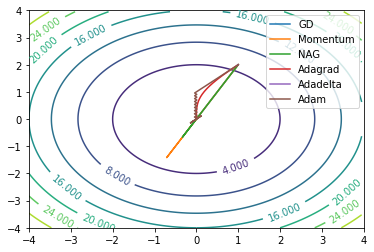

In [5]:
def func(X, Y):
    return X**2 + Y**2

N = 1000
start = np.array([1, 2])
make_plot(func, start, N)

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

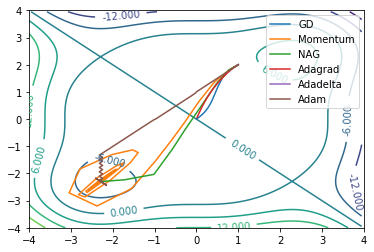

In [6]:
def func(X, Y):
    return X**2 * torch.sin(X) + Y**2 * torch.sin(Y)

N = 1000
start = np.array([1, 2])
make_plot(func, start, N)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

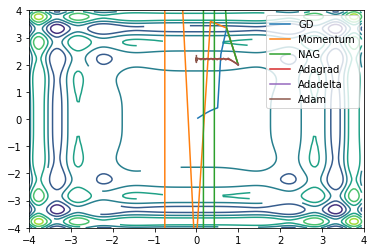

In [7]:
def func(X, Y):
    return X**2 * torch.sin(X**2) + Y**2 * torch.sin(Y**2)

N = 1000
start = np.array([1, 2])
make_plot(func, start, N)

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [8]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [9]:
def train(network, epochs, learning_rate, optim, ravel_init=True):
    loss = nn.NLLLoss()
    optimizer = optim(list(network.parameters()), learning_rate=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                if ravel_init:
                    X = X.view(X.size(0), -1)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                optimizer.step(lambda : loss_batch)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                if ravel_init:
                    X = X.view(X.size(0), -1)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 9... (Train/Test) NLL: 0.288/0.273	Accuracy: 0.917/0.920


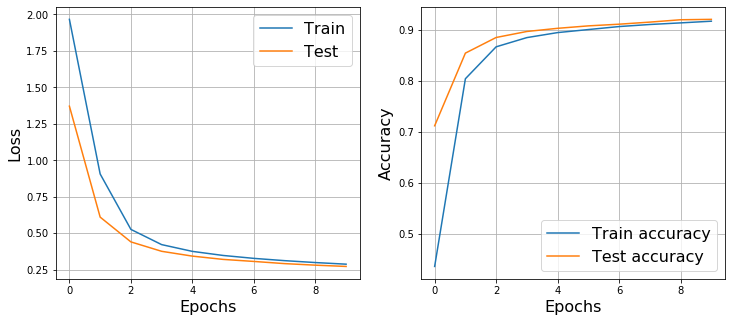

In [10]:
network = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
)
train(network, 10, 0.001, optim=GD)

Epoch 9... (Train/Test) NLL: 0.233/0.227	Accuracy: 0.933/0.935


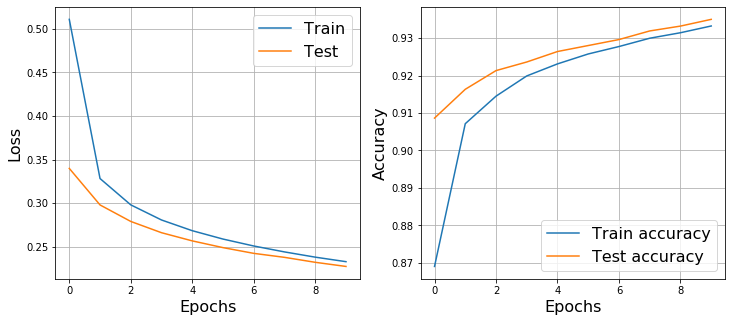

In [11]:
network = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
)
train(network, 10, 0.001, optim=Adagrad)

Epoch 9... (Train/Test) NLL: 2.009/1.982	Accuracy: 0.608/0.621


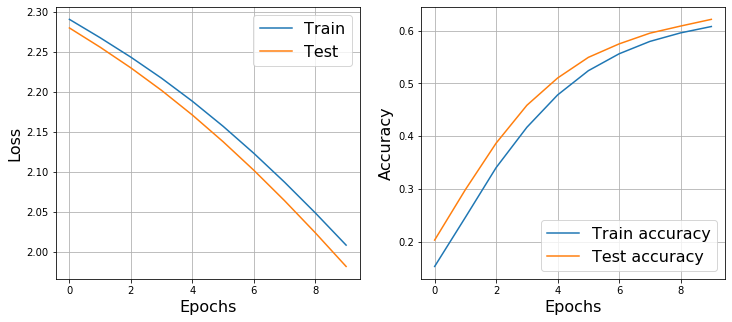

In [12]:
network = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
)
train(network, 10, 0.001, optim=Adadelta)

Epoch 9... (Train/Test) NLL: 0.099/0.287	Accuracy: 0.984/0.969


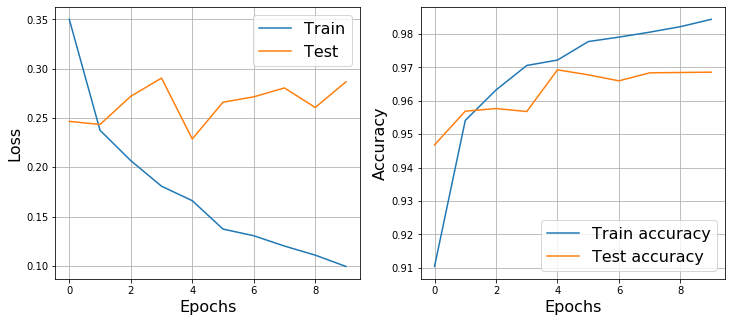

In [13]:
network = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
)
train(network, 10, 0.001, optim=Adam)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [14]:
image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding=1),
                                         nn.ReLU(),)
        self.linear_layers = nn.Sequential(nn.Linear(image_size // 2 * image_size // 2 * 16, 10),
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 9... (Train/Test) NLL: 0.156/0.141	Accuracy: 0.956/0.959


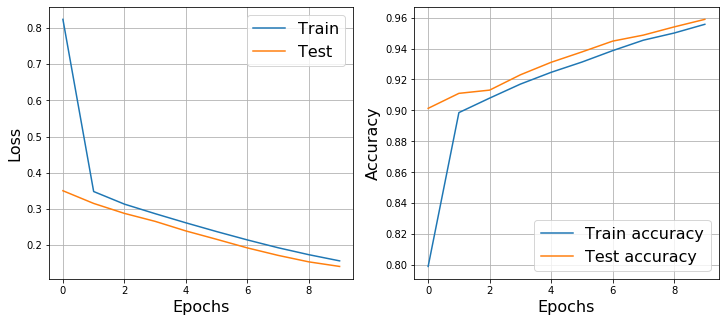

In [15]:
network = ConvClassifier(image_size=28)
train(network, 10, 0.001, ravel_init=False, optim=GD)

Epoch 9... (Train/Test) NLL: 0.183/0.173	Accuracy: 0.948/0.950


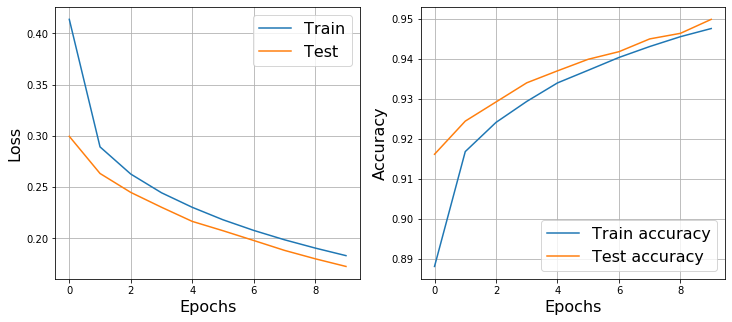

In [16]:
network = ConvClassifier(image_size=28)
train(network, 10, 0.001, ravel_init=False, optim=Adagrad)

Epoch 9... (Train/Test) NLL: 1.941/1.911	Accuracy: 0.688/0.711


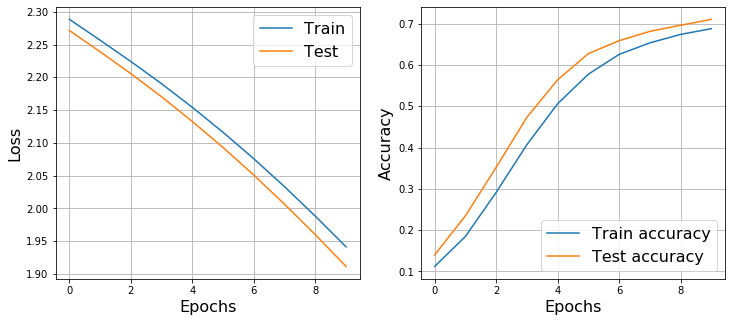

In [17]:
network = ConvClassifier(image_size=28)
train(network, 10, 0.001, ravel_init=False, optim=Adadelta)

Epoch 9... (Train/Test) NLL: 0.063/0.098	Accuracy: 0.990/0.986


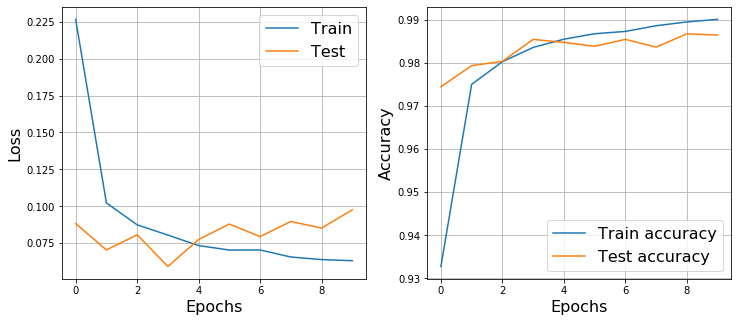

In [18]:
network = ConvClassifier(image_size=28)
train(network, 10, 0.001, ravel_init=False, optim=Adam)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: